In [1]:
import jax
import jax.numpy as jnp
import approx_post
import oed_toolbox
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.insert(0, '..')
import plotting_helpers
import computation_helpers

Plot settings:

In [3]:
# dpi of images displayed in notebook:
mpl.rcParams['figure.dpi'] = 100
# dpi of images saved to seperate folder:
mpl_save_dpi = 300
# Plot theme:
sns.set_theme(style='darkgrid')

Save directory for figs:

In [4]:
fig_save_dir = './figs/vi'
if not os.path.isdir(fig_save_dir):
    os.makedirs(fig_save_dir)

# Create Model + Data

In [7]:
def create_data(model, true_theta, noise_cov, num_samples, ndim, prngkey):
    mean = model(true_theta, 0)
    samples = jax.random.multivariate_normal(key=prngkey, mean=mean, cov=noise_cov, shape=(num_samples,))
    return samples.reshape(num_samples, -1)

In [8]:
# First, let's define a model:
ndim = 1
model_func = lambda theta, x: theta**2
model, model_grad = approx_post.models.from_jax(model_func)

In [28]:
# Create artificial data:
prngkey = jax.random.PRNGKey(10)
true_theta = jnp.array([2.5])
noise_cov = jnp.identity(ndim)
num_samples = 1
data = create_data(model_func, true_theta, noise_cov, num_samples, ndim, prngkey)
print(data)

[[4.9054594]]


In [29]:
# Create Gaussian approximate distribution:
approx_dist = approx_post.distributions.approx.Gaussian(ndim)

In [30]:
# Create Joint distribution from forward model:
prior_mean = jnp.zeros(ndim)
prior_cov = jnp.identity(ndim)
joint_dist = approx_post.distributions.joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)

# Reverse KL Approximation

In [31]:
reverse_approx = approx_post.distributions.approx.Gaussian(ndim)
prngkey = jax.random.PRNGKey(12)
loss = approx_post.losses.ELBO(joint_dist, use_reparameterisation=True)
optimiser = approx_post.optimisers.Adam()
loss = optimiser.fit(reverse_approx, loss, data, prngkey, verbose=True, max_iter=50, num_samples=1000)

Loss = 9.38978385925293, Params = Jaxtainer({'mean': DeviceArray([-0.09999999], dtype=float32), 'log_chol_diag': DeviceArray([0.1], dtype=float32)})
Loss = 9.072261810302734, Params = Jaxtainer({'mean': DeviceArray([-0.19616628], dtype=float32), 'log_chol_diag': DeviceArray([0.1960348], dtype=float32)})
Loss = 8.944905281066895, Params = Jaxtainer({'mean': DeviceArray([-0.29393485], dtype=float32), 'log_chol_diag': DeviceArray([0.26284942], dtype=float32)})
Loss = 9.053630828857422, Params = Jaxtainer({'mean': DeviceArray([-0.37431544], dtype=float32), 'log_chol_diag': DeviceArray([0.26708147], dtype=float32)})
Loss = 9.077865600585938, Params = Jaxtainer({'mean': DeviceArray([-0.41594565], dtype=float32), 'log_chol_diag': DeviceArray([0.23708391], dtype=float32)})
Loss = 8.979948043823242, Params = Jaxtainer({'mean': DeviceArray([-0.43530667], dtype=float32), 'log_chol_diag': DeviceArray([0.19281419], dtype=float32)})
Loss = 8.88690185546875, Params = Jaxtainer({'mean': DeviceArray([-

# Forward KL Approximation

In [20]:
forward_approx = approx_post.distributions.approx.Gaussian(ndim)
prngkey = jax.random.PRNGKey(12)
loss = approx_post.losses.ForwardKL(joint_dist, use_reparameterisation=False)
optimiser = approx_post.optimisers.Adam()
loss = optimiser.fit(forward_approx, loss, data, prngkey, verbose=True, max_iter=50, num_samples=1000)

Loss = 0.0011518960818648338, Params = Jaxtainer({'mean': DeviceArray([0.09969271], dtype=float32), 'log_chol_diag': DeviceArray([-0.09999787], dtype=float32)})
Loss = 0.0011291311820968986, Params = Jaxtainer({'mean': DeviceArray([0.02699205], dtype=float32), 'log_chol_diag': DeviceArray([-0.19754653], dtype=float32)})
Loss = 0.0011138251284137368, Params = Jaxtainer({'mean': DeviceArray([-0.04488465], dtype=float32), 'log_chol_diag': DeviceArray([-0.28886187], dtype=float32)})
Loss = 0.0011283113854005933, Params = Jaxtainer({'mean': DeviceArray([-0.05323817], dtype=float32), 'log_chol_diag': DeviceArray([-0.36303502], dtype=float32)})
Loss = 0.0011527284514158964, Params = Jaxtainer({'mean': DeviceArray([-0.02140239], dtype=float32), 'log_chol_diag': DeviceArray([-0.4064697], dtype=float32)})
Loss = 0.0011651678942143917, Params = Jaxtainer({'mean': DeviceArray([0.02388876], dtype=float32), 'log_chol_diag': DeviceArray([-0.418195], dtype=float32)})
Loss = 0.0011641924502328038, Para

# Plots

Create true posterior:

In [32]:
true_posterior = computation_helpers.construct_true_posterior(model_func, noise_cov, prior_mean, prior_cov,
                                                              theta_lims=(-5,5))

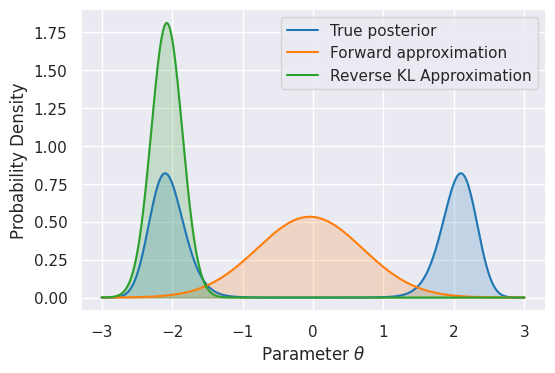

In [33]:
theta_plot = jnp.linspace(-3,3,1000).reshape(-1,1)
pdfs = {'True posterior': true_posterior(theta_plot, data, 0),
        'Forward approximation': jnp.exp(forward_approx.logpdf(theta_plot)),
        'Reverse KL Approximation': jnp.exp(reverse_approx.logpdf(theta_plot))}
plotting_helpers.plot_distributions(pdfs, theta_plot, 'Parameter $\\theta$')
plt.savefig(os.path.join(fig_save_dir, 'nonamortised_vi.png'), dpi=mpl_save_dpi, bbox_inches='tight')